# Visualization for family dataset results

In [1]:
import numpy as np
import pandas as pd
import config
from rule_comparison import plot_pie_chart, get_common_rules, display_comparison, get_unique_rules
from operator import itemgetter
from kb_extension import extend_kb
from ampligraph.latent_features import RandomBaseline


# random slection of candidates
import models
from rule_mining import rule_mining

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import copy


# family dataset
original_kb = np.loadtxt(config.family_dataset_path, dtype = 'object')
relations = config.family_relations
folder_path = "./family_max_entities_1000/"

# wn18rr dataset
#original_kb = np.loadtxt(config.wn18rr_dataset_path, dtype = 'object')
#relations = config.wn18rr_relations
#folder_path = "./family_max_entities_200/"

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


## Load and view raw data

In [85]:
# load saved rules
original_rules = pd.read_pickle(folder_path + "original_rules.pkl")
mined_rules = pd.read_pickle(folder_path + "mined_rules.pkl")
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters.pkl")
parameter_combinations = pd.read_pickle(folder_path + "parameter_combinations.pkl")
extension_sizes = pd.read_pickle(folder_path + "extension_sizes.pkl")

original_rules_median_PCA = original_rules["PCA Confidence"].median()
original_rules_median_HC = original_rules["Head Coverage"].median()

In [64]:
mined_rules_parameters

,Rule,Head Coverage,PCA Confidence,Positive Examples,PCA Body size,_Head Coverage,_PCA Confidence,_Positive Examples,_PCA Body size,PCA Diff,Pos Diff,Neg Diff,Entity_selection,Model,Candidate_criteria
0,?b relative ?a => ?a relative ?b,0.551117,0.846306,2566,3032,0.542929,0.838658,2599.0,3099.0,0.007648,-33.0,-34.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
1,?b child ?a => ?a mother ?b,0.978364,0.535350,16053,29986,0.975739,0.535790,16168.0,30176.0,-0.000440,-115.0,-75.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
2,?b spouse ?a => ?a spouse ?b,0.947832,0.992355,44132,44472,0.948547,0.992282,44871.0,45220.0,0.000073,-739.0,-9.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
3,?b mother ?a => ?a child ?b,0.247034,0.991906,16053,16184,0.248154,0.989353,16168.0,16342.0,0.002553,-115.0,-43.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
4,?b child ?a => ?a father ?b,0.942309,0.769746,47090,61176,0.941802,0.769786,47221.0,61343.0,-0.000040,-131.0,-36.0,probabilistic,ComplEx,"('rank_cutoff', 1)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,?a child ?g ?g sibling ?b => ?a child ?b,0.487174,0.850519,31658,37222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
90,?g sibling ?b ?a sibling ?g => ?a sibl...,0.721059,0.588151,54551,92750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
91,?h sibling ?a ?b sibling ?h => ?a sibl...,0.716023,0.584857,54170,92621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules
92,?a sibling ?h ?b sibling ?h => ?a sibl...,0.718680,0.590059,54371,92145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Original rules,Original rules,Original rules


<AxesSubplot:ylabel='Frequency'>

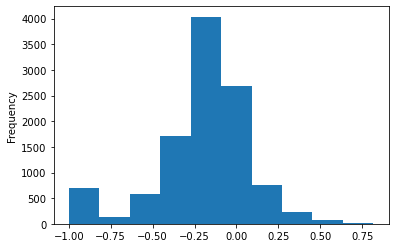

In [39]:
mined_rules_parameters['PCA Diff'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

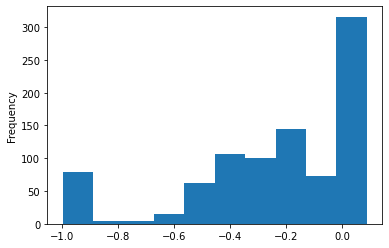

In [40]:
mined_rules_parameters = mined_rules_parameters.loc[((mined_rules_parameters["Candidate_criteria"] == "('rank_cutoff', 1)") | (mined_rules_parameters["Candidate_criteria"] == 'Original rules') | (mined_rules_parameters["Candidate_criteria"] == 'Rand cand')) & (mined_rules_parameters["Entity_selection"] == 'least_frequent')]
mined_rules_parameters['PCA Diff'].plot.hist()

### Examine size of kb extension

WARNING - No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


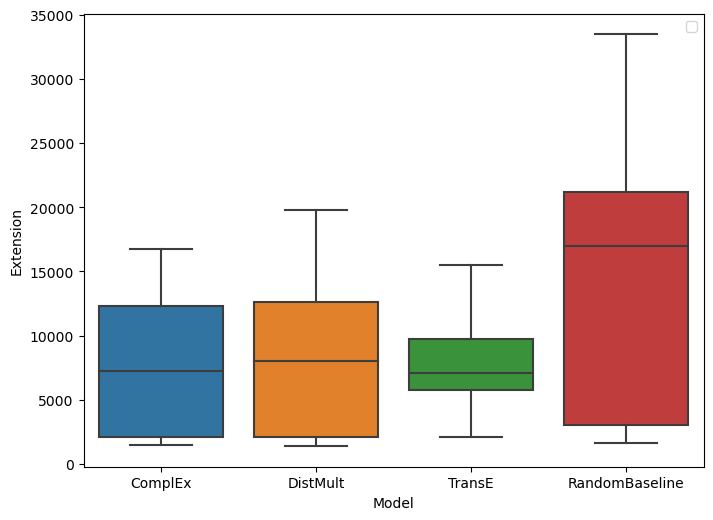

In [4]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Extension", data=extension_sizes)
#plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.legend()

## Add true randombasleine
Randomly select candidates and mine rules from the resulting expanded kb. The number of candidates to randomly add is the mean of the number of candidates added by ComplEx ranking.

In [ ]:
# used to determine the number of candidates to randomly add to kb
mean_complEx_extension_size = int(extension_sizes.loc[extension_sizes["Model"] == 'ComplEx'].Extension.mean())


# construct filler model
filler_model = RandomBaseline()
filler_model.fit(original_kb)

# add rules mined from randomly selected candidates
extended_kb, admitted_candidates = extend_kb(original_kb, relations, filler_model, "random", ("random", mean_complEx_extension_size), max_entities=config.max_entities)
rules = rule_mining(extended_kb)
number_of_rules = len(rules)
parameter_list = ["Rand cand","Rand cand","Rand cand"]
parameter_full = [parameter_list for j in range(number_of_rules)]
parameter_full_df = pd.DataFrame(parameter_full, columns=["Entity_selection", "Model", "Candidate_criteria"])
original_rules_parameters= pd.concat([rules, parameter_full_df], axis=1)
#mined_rules.append(original_rules_parameters)
mined_rules_parameters = pd.concat([mined_rules_parameters,original_rules_parameters])

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/ampligraph/latent_features/models/EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':


In [ ]:
mined_rules_parameters.to_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [56]:
mined_rules_parameters = pd.read_pickle(folder_path + "mined_rules_parameters_w_random.pkl")

In [87]:
# limited to rules mined with candidates ranked 1
mined_rules_parameters = mined_rules_parameters.loc[((mined_rules_parameters["Candidate_criteria"] == "('rank_cutoff', 1)") | (mined_rules_parameters["Candidate_criteria"] == 'Original rules') | (mined_rules_parameters["Candidate_criteria"] == 'Rand cand')) & (mined_rules_parameters["Entity_selection"] == 'least_frequent')]

## Parameter 1: embedding model

In [7]:
def get_dataframe_to_plot(all_rules, parameter_type, parameter_name):
    """
    Generate dataframe containing rules mined with certain parameter value
    """
    rules = all_rules.loc[(all_rules[parameter_type] == parameter_name)]
    return rules

### Parameter 1: KG embeddings

In [49]:
complEx_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "ComplEx")
distMult_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "DistMult")
transE_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "TransE")
randomBaseline_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "RandomBaseline")
random_rules = get_dataframe_to_plot(mined_rules_parameters, "Model", "Rand cand")

<AxesSubplot:title={'center':'PCA difference for complEx'}, ylabel='Frequency'>

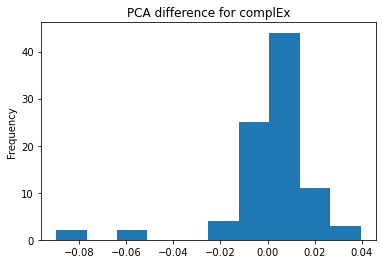

In [50]:
complEx_rules['PCA Diff'].plot.hist(title = "PCA difference for complEx")

<AxesSubplot:title={'center':'PCA difference for distMult'}, ylabel='Frequency'>

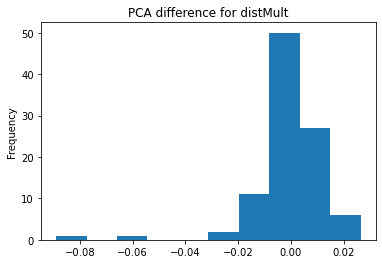

In [51]:
distMult_rules['PCA Diff'].plot.hist(title = "PCA difference for distMult")

<AxesSubplot:title={'center':'PCA difference for transE'}, ylabel='Frequency'>

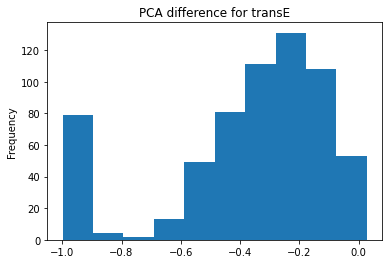

In [52]:
transE_rules['PCA Diff'].plot.hist(title = "PCA difference for transE")

<AxesSubplot:title={'center':'PCA difference for randomBaseline'}, ylabel='Frequency'>

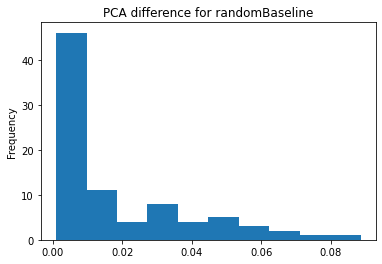

In [53]:
randomBaseline_rules['PCA Diff'].plot.hist(title = "PCA difference for randomBaseline")

In [54]:
complEx_PCA_mean = complEx_rules['PCA Confidence'].mean()
distMult_PCA_mean = distMult_rules['PCA Confidence'].mean()
transE_PCA_mean = transE_rules['PCA Confidence'].mean()
randomBaseline_PCA_mean = randomBaseline_rules['PCA Confidence'].mean()
random_PCA_mean = random_rules['PCA Confidence'].mean()

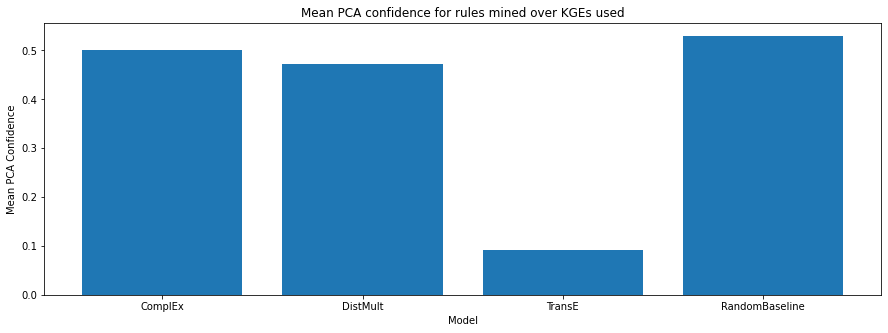

In [55]:
names = ["ComplEx", "DistMult", "TransE", "RandomBaseline", "True Random"]
values = [complEx_PCA_mean, distMult_PCA_mean, transE_PCA_mean, randomBaseline_PCA_mean, random_PCA_mean]
fig = plt.figure(figsize=(15,5))
plt.bar(names, values)
plt.ylabel('Mean PCA Confidence')
plt.xlabel('Model')
plt.title("Mean PCA confidence for rules mined over KGEs used");


complEx
Mined 86/94 original rules, and 5 new rules.
Rules missed:
?a  child  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?h  father  ?b  ?a  father  ?h   => ?a  relative  ?b
?a  father  ?h  ?h  sibling  ?b   => ?a  relative  ?b
?a  child  ?h  ?b  spouse  ?h   => ?a  relative  ?b
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b
?g  relative  ?b  ?a  relative  ?g   => ?a  relative  ?b
?a  father  ?g  ?g  spouse  ?b   => ?a  mother  ?b
?b  child  ?g  ?g  sibling  ?a   => ?a  father  ?b


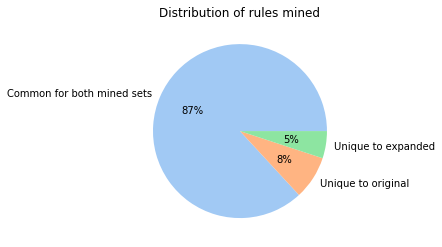


distMult
Mined 80/94 original rules, and 18 new rules.
Rules missed:
?a  child  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?h  father  ?b  ?a  father  ?h   => ?a  relative  ?b
?a  father  ?h  ?h  sibling  ?b   => ?a  relative  ?b
?g  child  ?b  ?a  child  ?g   => ?a  relative  ?b
?a  child  ?h  ?b  spouse  ?h   => ?a  relative  ?b
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b
?b  relative  ?h  ?h  sibling  ?a   => ?a  relative  ?b
?h  father  ?a  ?b  relative  ?h   => ?a  relative  ?b
?b  child  ?h  ?h  father  ?a   => ?a  spouse  ?b
?a  father  ?g  ?g  spouse  ?b   => ?a  mother  ?b
?b  child  ?g  ?g  sibling  ?a   => ?a  father  ?b
?g  child  ?a  ?b  spouse  ?g   => ?a  father  ?b
?g  child  ?b  ?a  spouse  ?g   => ?a  child  ?b
?g  sibling  ?b  ?a  sibling  ?g   => ?a  sibling  ?b


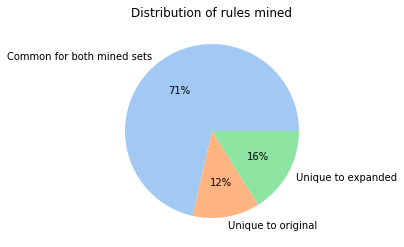


transE
Mined 76/94 original rules, and 774 new rules.
Rules missed:
?g  mother  ?b  ?a  relative  ?g   => ?a  relative  ?b
?a  relative  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?a  child  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?g  child  ?b  ?a  child  ?g   => ?a  relative  ?b
?a  relative  ?g  ?g  sibling  ?b   => ?a  relative  ?b
?g  child  ?b  ?a  relative  ?g   => ?a  relative  ?b
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b
?g  father  ?b  ?a  relative  ?g   => ?a  relative  ?b
?g  relative  ?b  ?a  relative  ?g   => ?a  relative  ?b
?a  father  ?g  ?g  spouse  ?b   => ?a  mother  ?b
?a  child  ?g  ?g  mother  ?b   => ?a  spouse  ?b
?a  child  ?g  ?g  father  ?b   => ?a  spouse  ?b
?b  child  ?g  ?g  sibling  ?a   => ?a  mother  ?b
?b  child  ?g  ?g  sibling  ?a   => ?a  father  ?b
?g  child  ?a  ?b  spouse  ?g   => ?a  father  ?b
?g  child  ?b  ?a  spouse  ?g   => ?a  child  ?b
?a  child  ?g  ?g  sibling  ?b   => ?a  child  ?b
?g  sibling  ?b  ?a  sibling  ?g   => ?

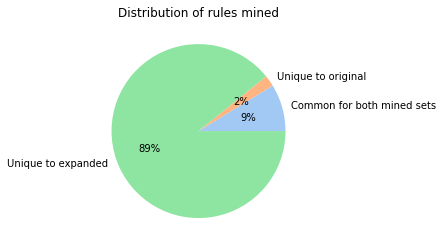


randomBaseline
Mined 79/94 original rules, and 6 new rules.
Rules missed:
?a  child  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?g  father  ?a  ?g  spouse  ?b   => ?a  relative  ?b
?h  father  ?b  ?a  father  ?h   => ?a  relative  ?b
?a  mother  ?h  ?b  relative  ?h   => ?a  relative  ?b
?a  father  ?h  ?h  sibling  ?b   => ?a  relative  ?b
?h  father  ?a  ?b  spouse  ?h   => ?a  relative  ?b
?a  child  ?h  ?b  spouse  ?h   => ?a  relative  ?b
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b
?h  father  ?a  ?b  relative  ?h   => ?a  relative  ?b
?g  relative  ?b  ?a  relative  ?g   => ?a  relative  ?b
?a  father  ?g  ?g  spouse  ?b   => ?a  mother  ?b
?a  child  ?g  ?g  mother  ?b   => ?a  spouse  ?b
?a  child  ?g  ?g  father  ?b   => ?a  spouse  ?b
?b  child  ?g  ?g  sibling  ?a   => ?a  mother  ?b
?g  sibling  ?b  ?a  sibling  ?g   => ?a  sibling  ?b


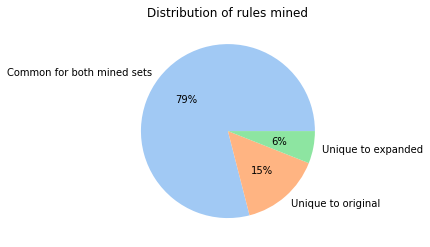

In [88]:
display_comparison("complEx", original_rules, complEx_rules.drop_duplicates("Rule"))
display_comparison("distMult", original_rules, distMult_rules.drop_duplicates("Rule"))
display_comparison("transE", original_rules, transE_rules.drop_duplicates("Rule"))
display_comparison("randomBaseline", original_rules, randomBaseline_rules.drop_duplicates("Rule"))
#display_comparison("random", original_rules, random_rules.drop_duplicates("Rule"))

Text(40, -0.05, '86')

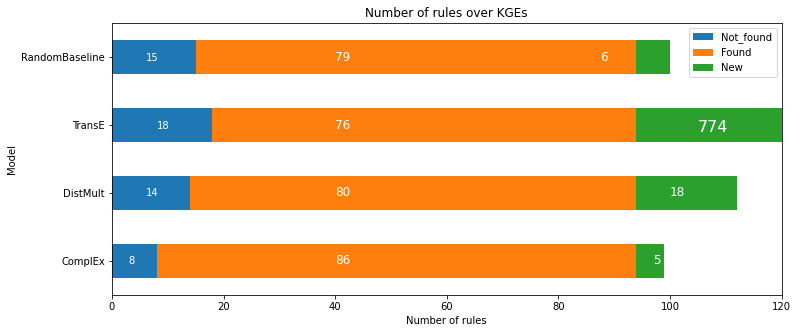

In [89]:
df = pd.DataFrame(rule_dist_df.set_index('Model'))
ax = df.plot.barh(figsize = (12, 5), title = "Number of rules over KGEs", stacked=True, xlim = (0,120), legend = True)
ax.set_xlabel('Number of rules')

randomBaseline_not_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'RandomBaseline')].Not_found.values[0]
ax.annotate(str(randomBaseline_not_found_rules), xy =(int(randomBaseline_not_found_rules/2)-1,2.95), color = "white")
randomBaseline_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'RandomBaseline')].Found.values[0]
ax.annotate(str(randomBaseline_found_rules), xy =(40,2.95), color = "white", fontsize=12)
randomBaseline_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'RandomBaseline')].New.values[0]
ax.annotate(str(randomBaseline_new_rules), xy =(87.5,2.95), color = "white", fontsize=12)

transE_not_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].Not_found.values[0]
ax.annotate(str(transE_not_found_rules), xy =(int(transE_not_found_rules/2)-1,1.95), color = "white")
transE_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].New.values[0]
ax.annotate(str(transE_new_rules), xy =(105,1.9), color = "white", fontsize=16)
transE_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'TransE')].Found.values[0]
ax.annotate(str(transE_found_rules), xy =(40,1.95), color = "white", fontsize=12)

distMult_not_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].Not_found.values[0]
ax.annotate(str(distMult_not_found_rules), xy =(int(distMult_not_found_rules/2)-1,0.95), color = "white")
distMult_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].New.values[0]
ax.annotate(str(distMult_new_rules), xy =(100,0.95), color = "white", fontsize=12)
distMult_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'DistMult')].Found.values[0]
ax.annotate(str(distMult_found_rules), xy =(40,0.95), color = "white", fontsize=12)

randomBaseline_not_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].Not_found.values[0]
ax.annotate(str(randomBaseline_not_found_rules), xy =(int(randomBaseline_not_found_rules/2)-1,-0.05), color = "white")
complEx_new_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].New.values[0]
ax.annotate(str(complEx_new_rules), xy =(97,-0.05), color = "white", fontsize=12)
complEx_found_rules = rule_dist_df.loc[(rule_dist_df['Model'] == 'ComplEx')].Found.values[0]
ax.annotate(str(complEx_found_rules), xy =(40,-0.05), color = "white", fontsize=12)

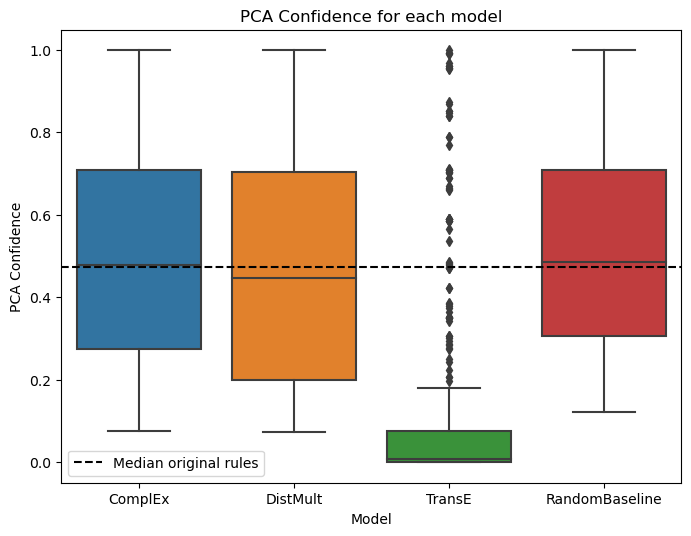

In [15]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.title("PCA Confidence for each model")
plt.legend()
plt.savefig("Max_entities=250_randcand=600_rank=1.png")

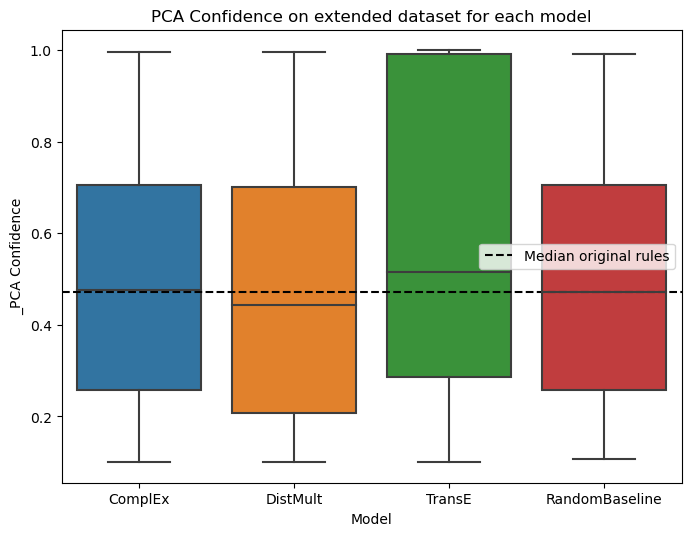

In [84]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="_PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color="black", label="Median original rules", linestyle="--")
plt.title("PCA Confidence on extended dataset for each model")
plt.legend()
plt.savefig("Max_entities=250_randcand=600_rank=1.png")

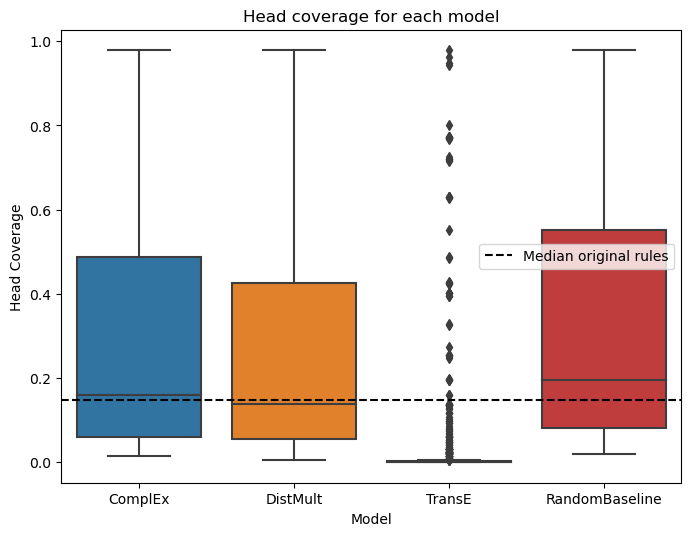

In [16]:
plt.subplots(figsize=(8,6), dpi=100)
ax = sns.boxplot(x="Model", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each model")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

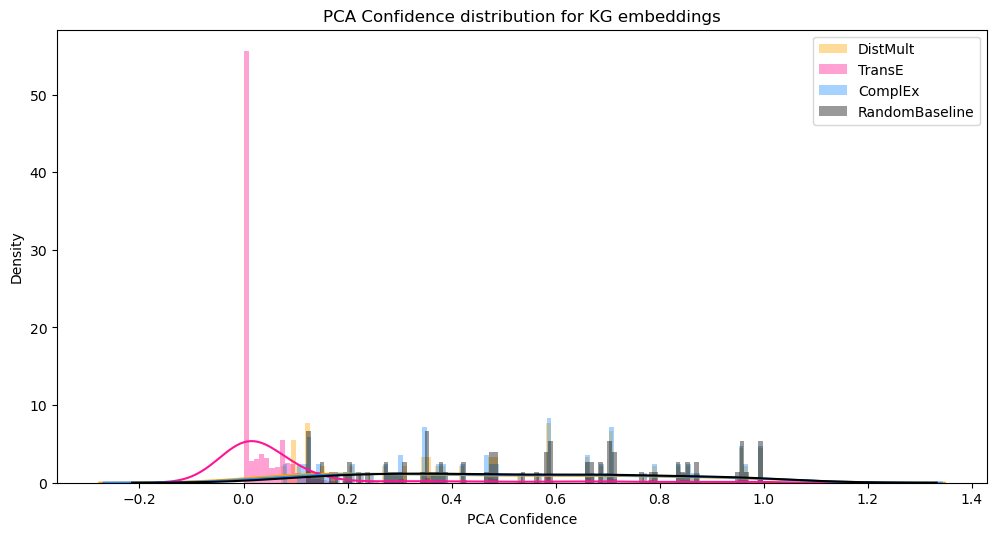

In [17]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["PCA Confidence"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["PCA Confidence"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot(randomBaseline_rules["PCA Confidence"] , color="black", bins = 100, label="RandomBaseline")


plt.title('PCA Confidence distribution for KG embeddings')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

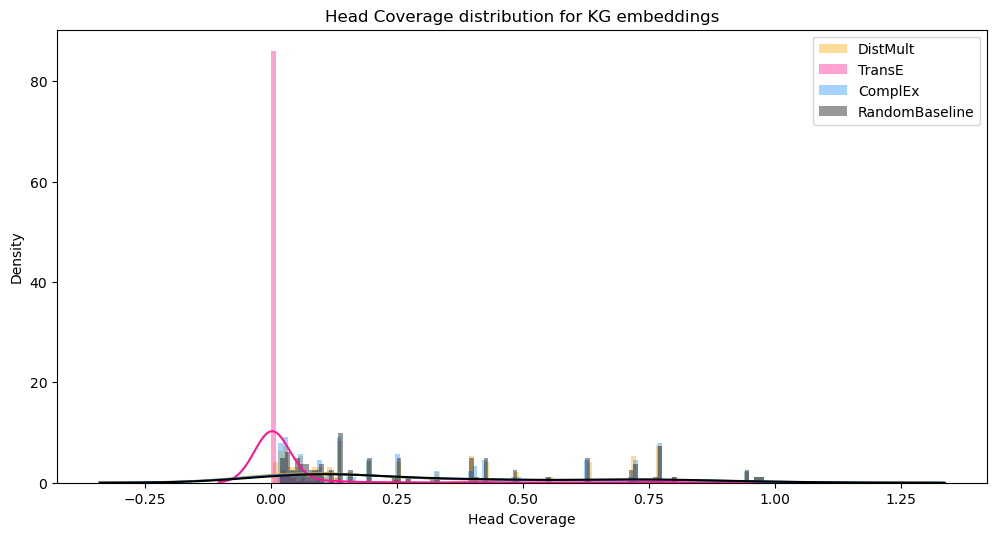

In [18]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(distMult_rules["Head Coverage"] , color="orange", bins = 100, label="DistMult")
sns.distplot(transE_rules["Head Coverage"] , color="deeppink", bins = 100, label="TransE")
sns.distplot(complEx_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="ComplEx")
sns.distplot( randomBaseline_rules["Head Coverage"] , color="black", bins = 100, label="RandomBaseline")


plt.title('Head Coverage distribution for KG embeddings')
plt.legend();

### Parameter 2: entity selection method

In [65]:
random_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "random")
most_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "most_frequent")
least_frequent_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "least_frequent")
probabilistic_entity_rules = get_dataframe_to_plot(mined_rules_parameters, "Entity_selection", "probabilistic")


Random selecction
Mined 92/94 original rules, and 901 new rules.
Rules missed:
?a  child  ?g  ?g  spouse  ?b   => ?a  relative  ?b
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b


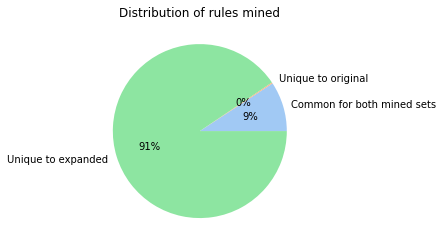


Most frequent
Mined 92/94 original rules, and 669 new rules.
Rules missed:
?h  father  ?b  ?a  father  ?h   => ?a  relative  ?b
?a  father  ?h  ?h  sibling  ?b   => ?a  relative  ?b


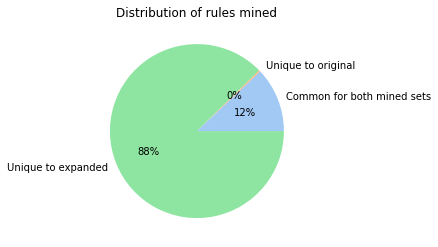


least frequent
Mined 93/94 original rules, and 858 new rules.
Rules missed:
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b


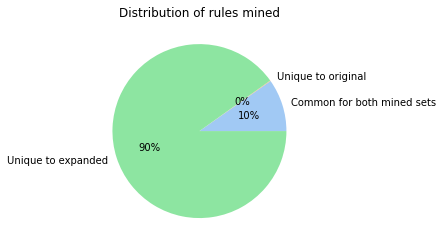


Probabilistic selection
Mined 94/94 original rules, and 925 new rules.


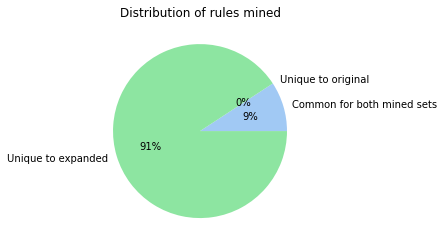

In [66]:
display_comparison("Random selecction", original_rules, random_entity_rules.drop_duplicates("Rule"))
display_comparison("Most frequent", original_rules, most_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("least frequent", original_rules, least_frequent_entity_rules.drop_duplicates("Rule"))
display_comparison("Probabilistic selection", original_rules, probabilistic_entity_rules.drop_duplicates("Rule"))

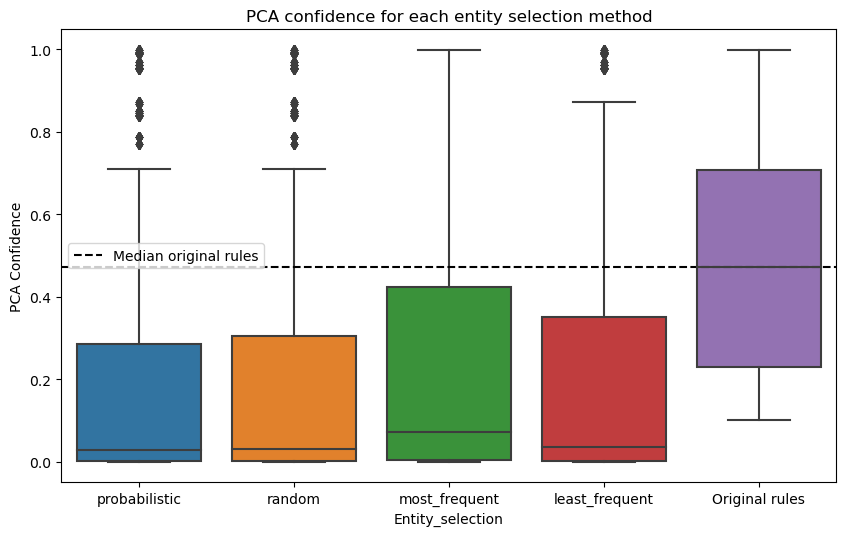

In [67]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for each entity selection method")
plt.legend()

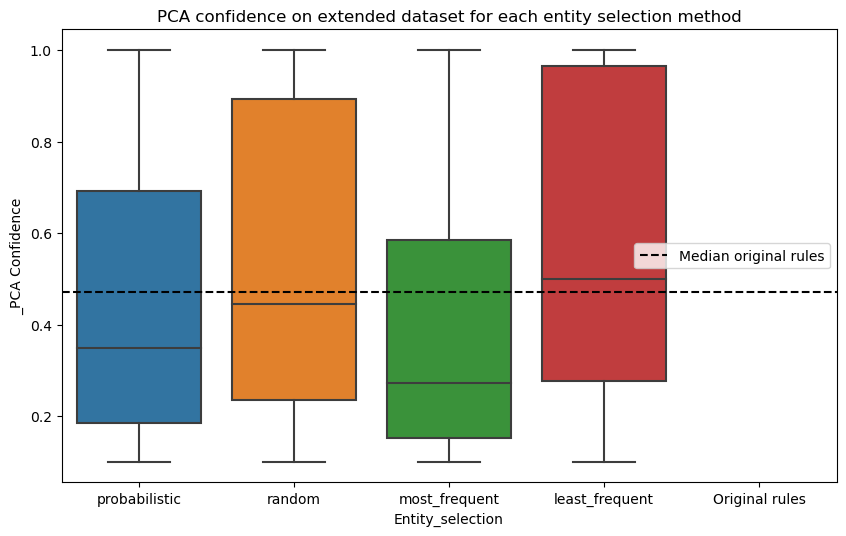

In [81]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="_PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence on extended dataset for each entity selection method")
plt.legend()

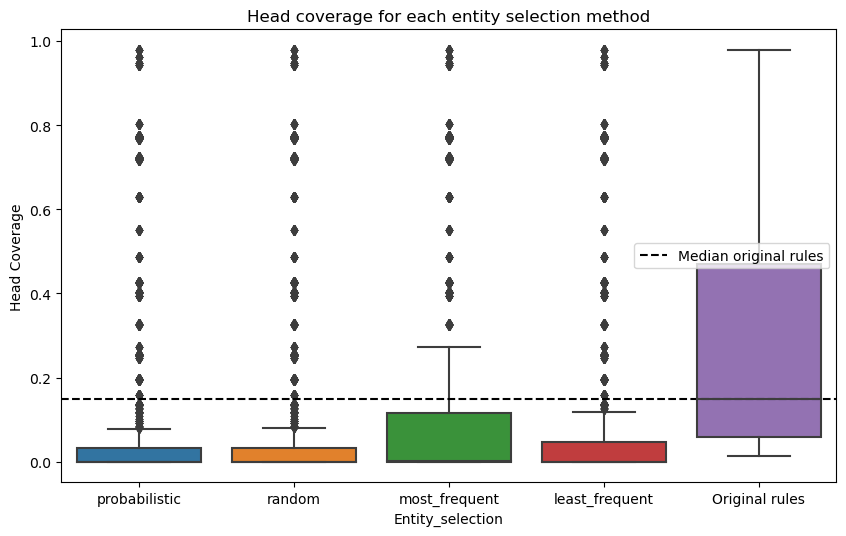

In [68]:
plt.subplots(figsize=(10,6), dpi=100)
ax = sns.boxplot(x="Entity_selection", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for each entity selection method")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

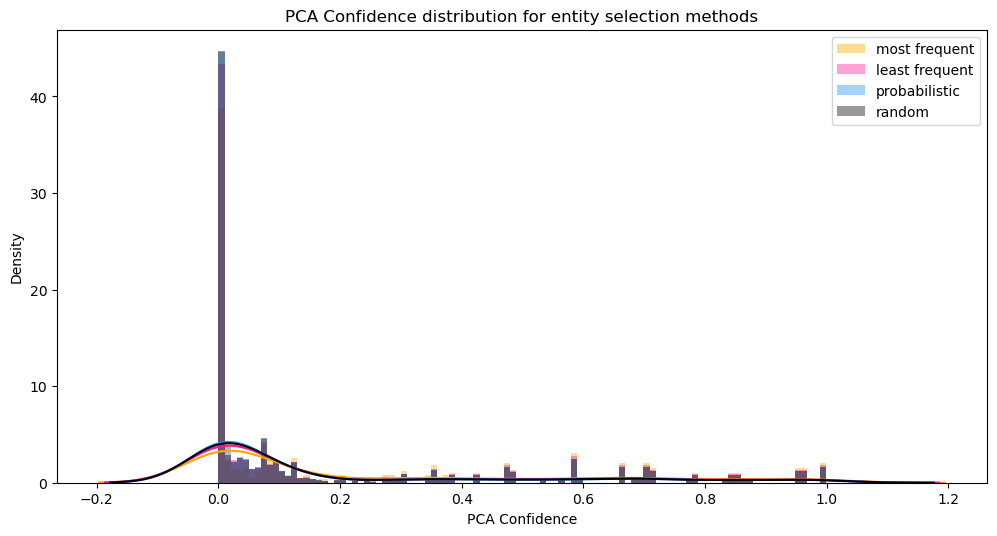

In [69]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["PCA Confidence"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["PCA Confidence"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["PCA Confidence"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["PCA Confidence"] , color="black", bins = 100, label="random")


plt.title('PCA Confidence distribution for entity selection methods')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

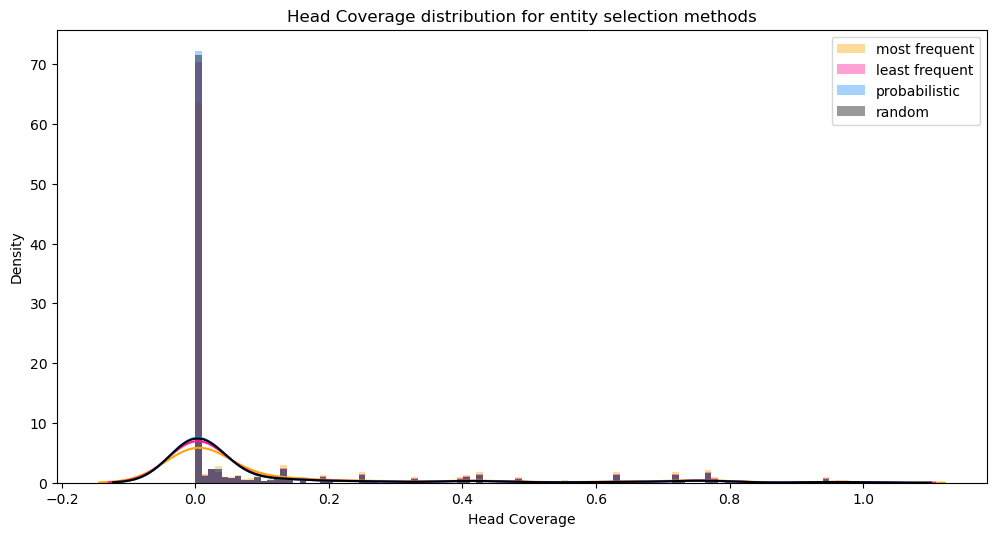

In [70]:
plt.subplots(figsize=(12,6), dpi=100)
sns.distplot(most_frequent_entity_rules["Head Coverage"] , color="orange", bins = 100, label="most frequent")
sns.distplot(least_frequent_entity_rules["Head Coverage"] , color="deeppink", bins = 100, label="least frequent")
sns.distplot( probabilistic_entity_rules["Head Coverage"] , color="dodgerblue", bins = 100, label="probabilistic")
sns.distplot(random_entity_rules["Head Coverage"] , color="black", bins = 100, label="random")


plt.title('Head Coverage distribution for entity selection methods')
plt.legend();

### Parameter 3: candidate admittance criteria


('rank_cutoff', 1)
Mined 94/94 original rules, and 821 new rules.


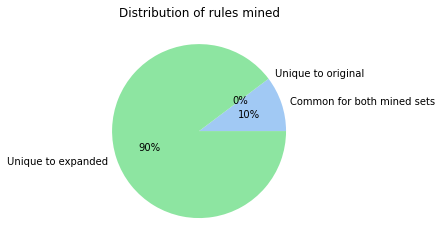


('rank_cutoff', 4)
Mined 94/94 original rules, and 916 new rules.


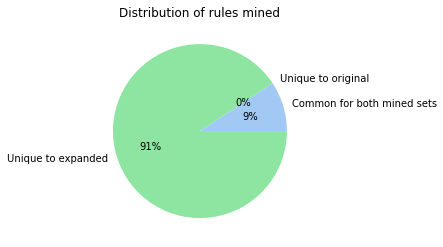


('rank_cutoff', 7)
Mined 92/94 original rules, and 983 new rules.
Rules missed:
?g  mother  ?a  ?b  relative  ?g   => ?a  relative  ?b
?g  father  ?b  ?a  relative  ?g   => ?a  relative  ?b


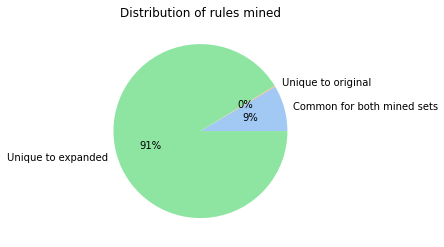

In [71]:
mined_rules_parameters['Candidate_criteria'] =  mined_rules_parameters.Candidate_criteria.astype(str)

for rank in config.rank_cutoffs:
    rank_df = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    display_comparison(str(rank), original_rules, rank_df.drop_duplicates("Rule"))

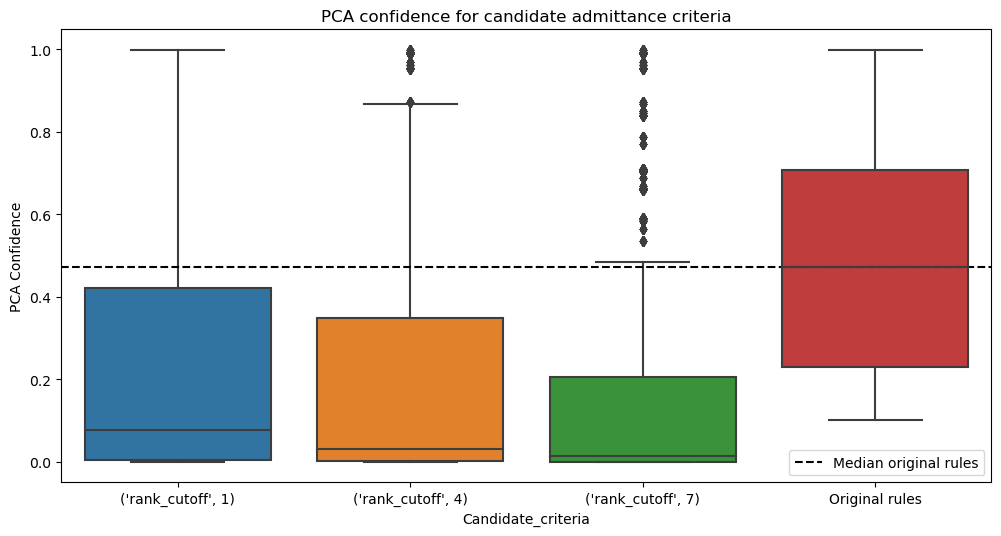

In [72]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="PCA Confidence", data=mined_rules_parameters)
plt.axhline(original_rules_median_PCA, color = "black", label="Median original rules", linestyle="--")
plt.title("PCA confidence for candidate admittance criteria")

plt.legend()

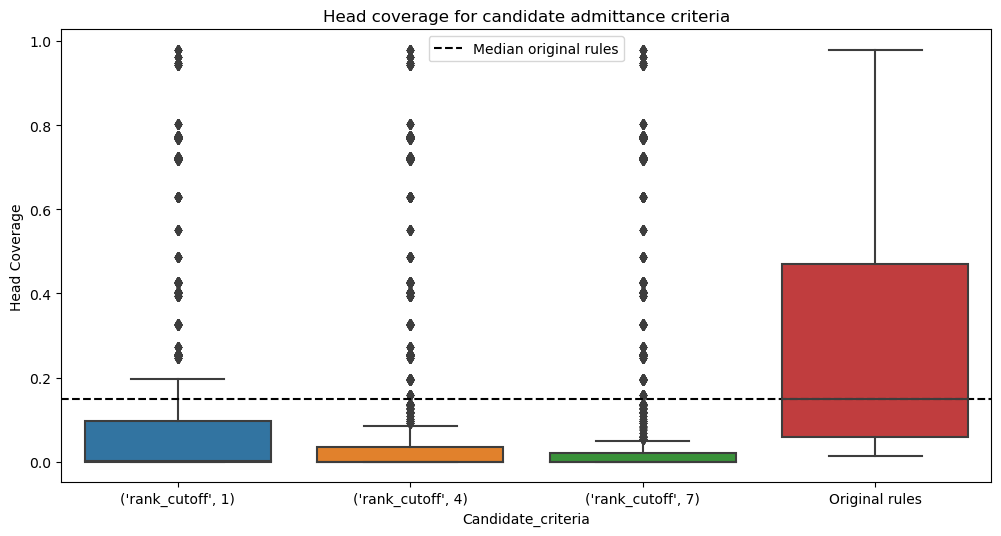

In [73]:
plt.subplots(figsize=(12,6), dpi=100)
ax = sns.boxplot(x="Candidate_criteria", y="Head Coverage", data=mined_rules_parameters)
plt.axhline(original_rules_median_HC, color = "black", label="Median original rules", linestyle="--")
plt.title("Head coverage for candidate admittance criteria")
plt.legend()

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

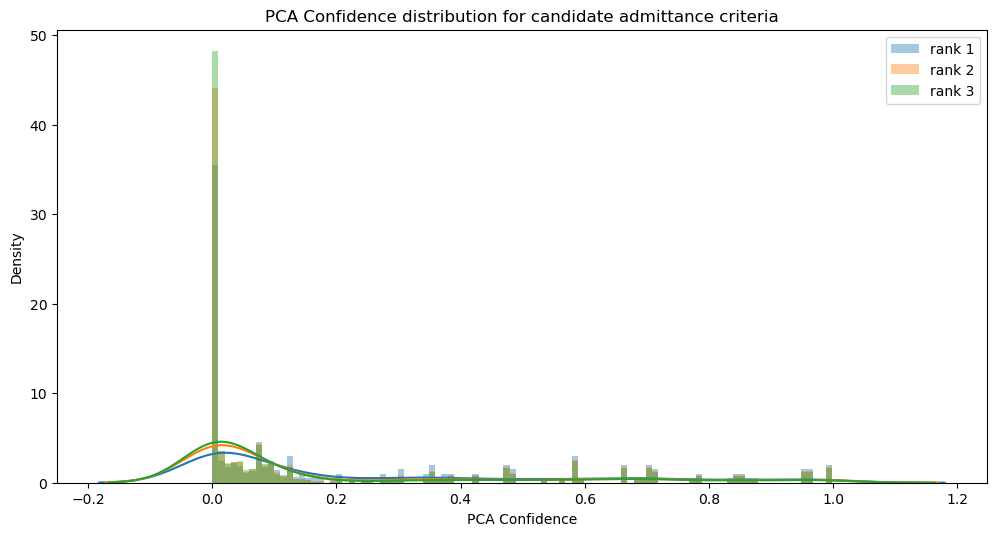

In [74]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["PCA Confidence"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('PCA Confidence distribution for candidate admittance criteria')
plt.legend();

/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Home/siv30/fak006/miniconda/envs/ampligraph/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

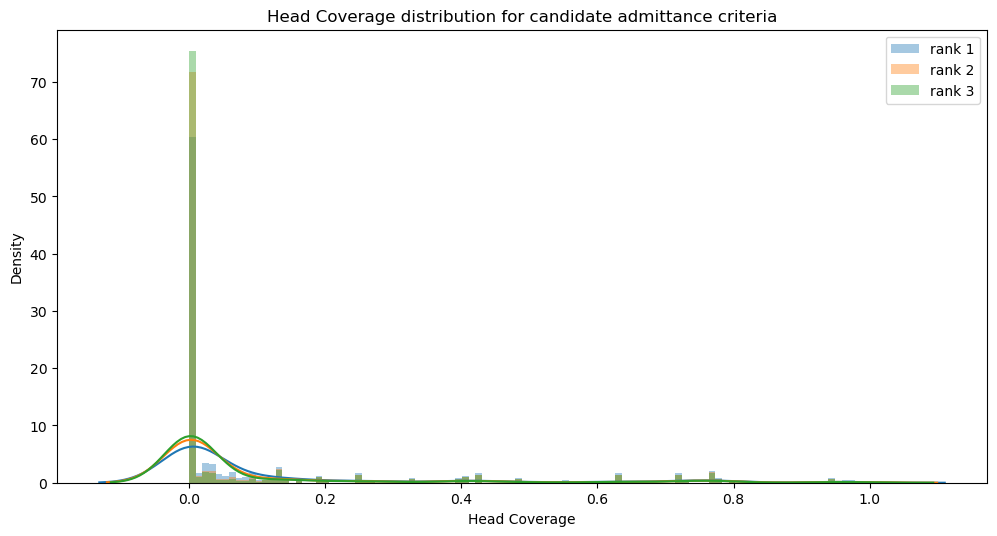

In [75]:
plt.subplots(figsize=(12,6), dpi=100)
for i, rank in enumerate(config.rank_cutoffs):
    rules_set = get_dataframe_to_plot(mined_rules_parameters, "Candidate_criteria", str(rank))
    sns.distplot(rules_set["Head Coverage"] , color=sns.color_palette()[i], bins = 100, label="rank " +str(i+1))
plt.title('Head Coverage distribution for candidate admittance criteria')
plt.legend();

### PCA Confidence vs Head Coverage

These plots visualize too many datapoints so it is only confusing to look at these plots

In [76]:
def plot_scatterplot(mined_rules_df, parameter="Model"):
    plt.subplots(figsize=(12,6), dpi=100)
    plot = sns.scatterplot(data=mined_rules_df.sample(frac=1), x="PCA Confidence", y="Head Coverage", hue=parameter, alpha=1)
    #plot.set_xlim(0.09, 0.5)
    #plot.set_ylim(0, 0.16)
    plot.set_title("PCA Confidence vs Head coverage per " +parameter.lower())
    plt.legend()

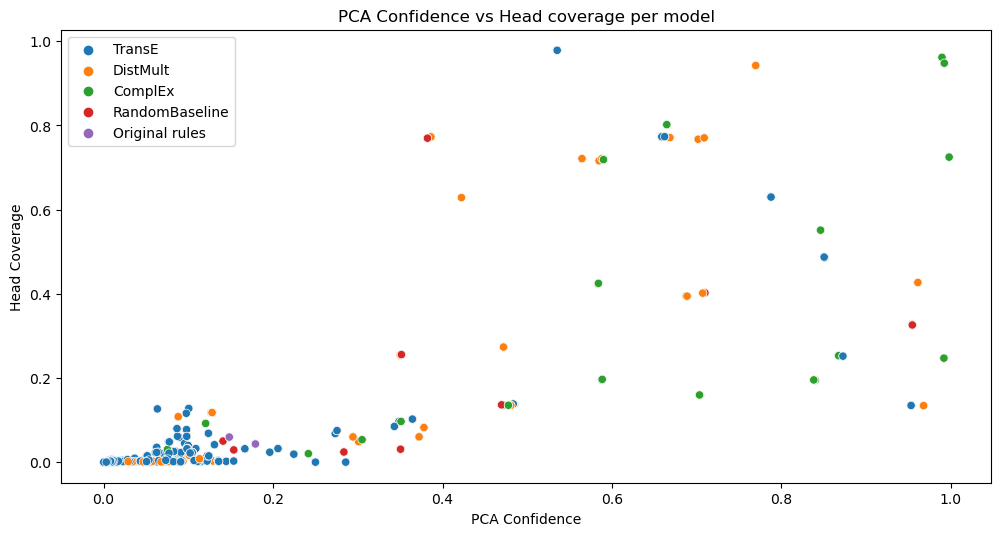

In [77]:
plot_scatterplot(mined_rules_parameters, parameter="Model")

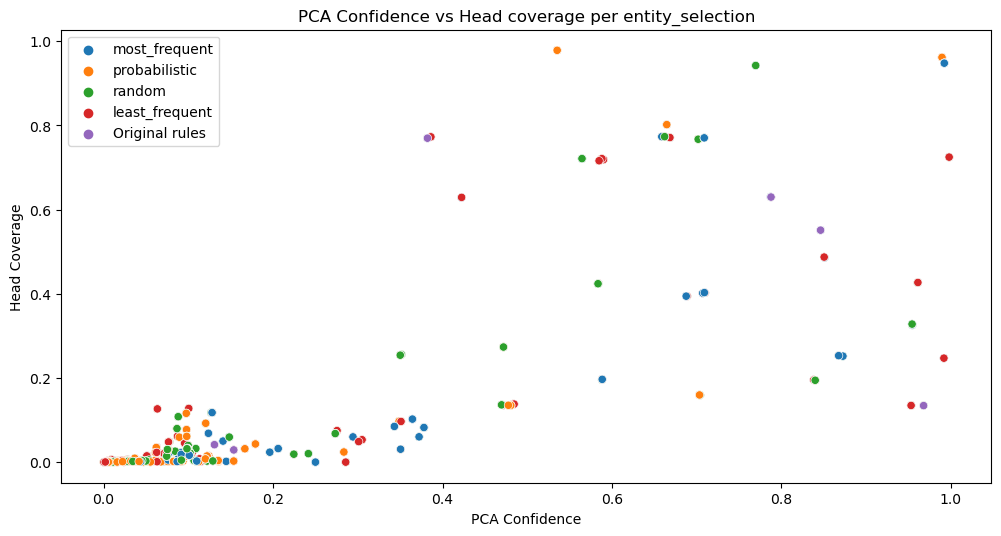

In [78]:
plot_scatterplot(mined_rules_parameters, parameter="Entity_selection")

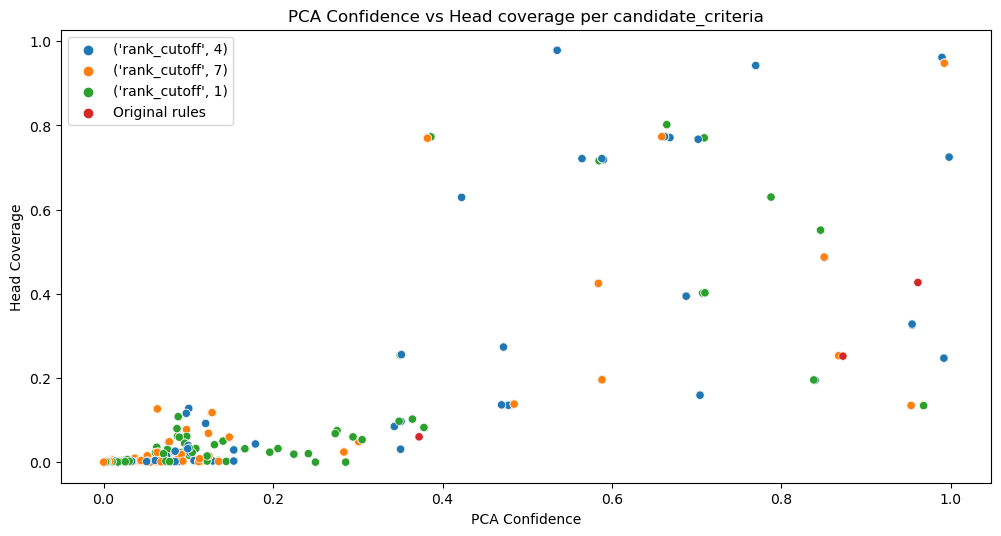

In [79]:
plot_scatterplot(mined_rules_parameters, parameter="Candidate_criteria")